In [1]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth

dry = True

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [212]:
from scipy import stats

def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "readCount"]), [bis_df, nano_df])
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd", "modification_type"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd", "modification_type"], 
                                  j="method", sep="_", suffix="\D+")
    return wide_merged.reset_index(drop=True), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

/tmp/ipykernel_303022/1781403897.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax4)
/tmp/ipykernel_303022/1781403897.py:63: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax5)
/tmp/ipykernel_303022/1781403897.py:71: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax6)


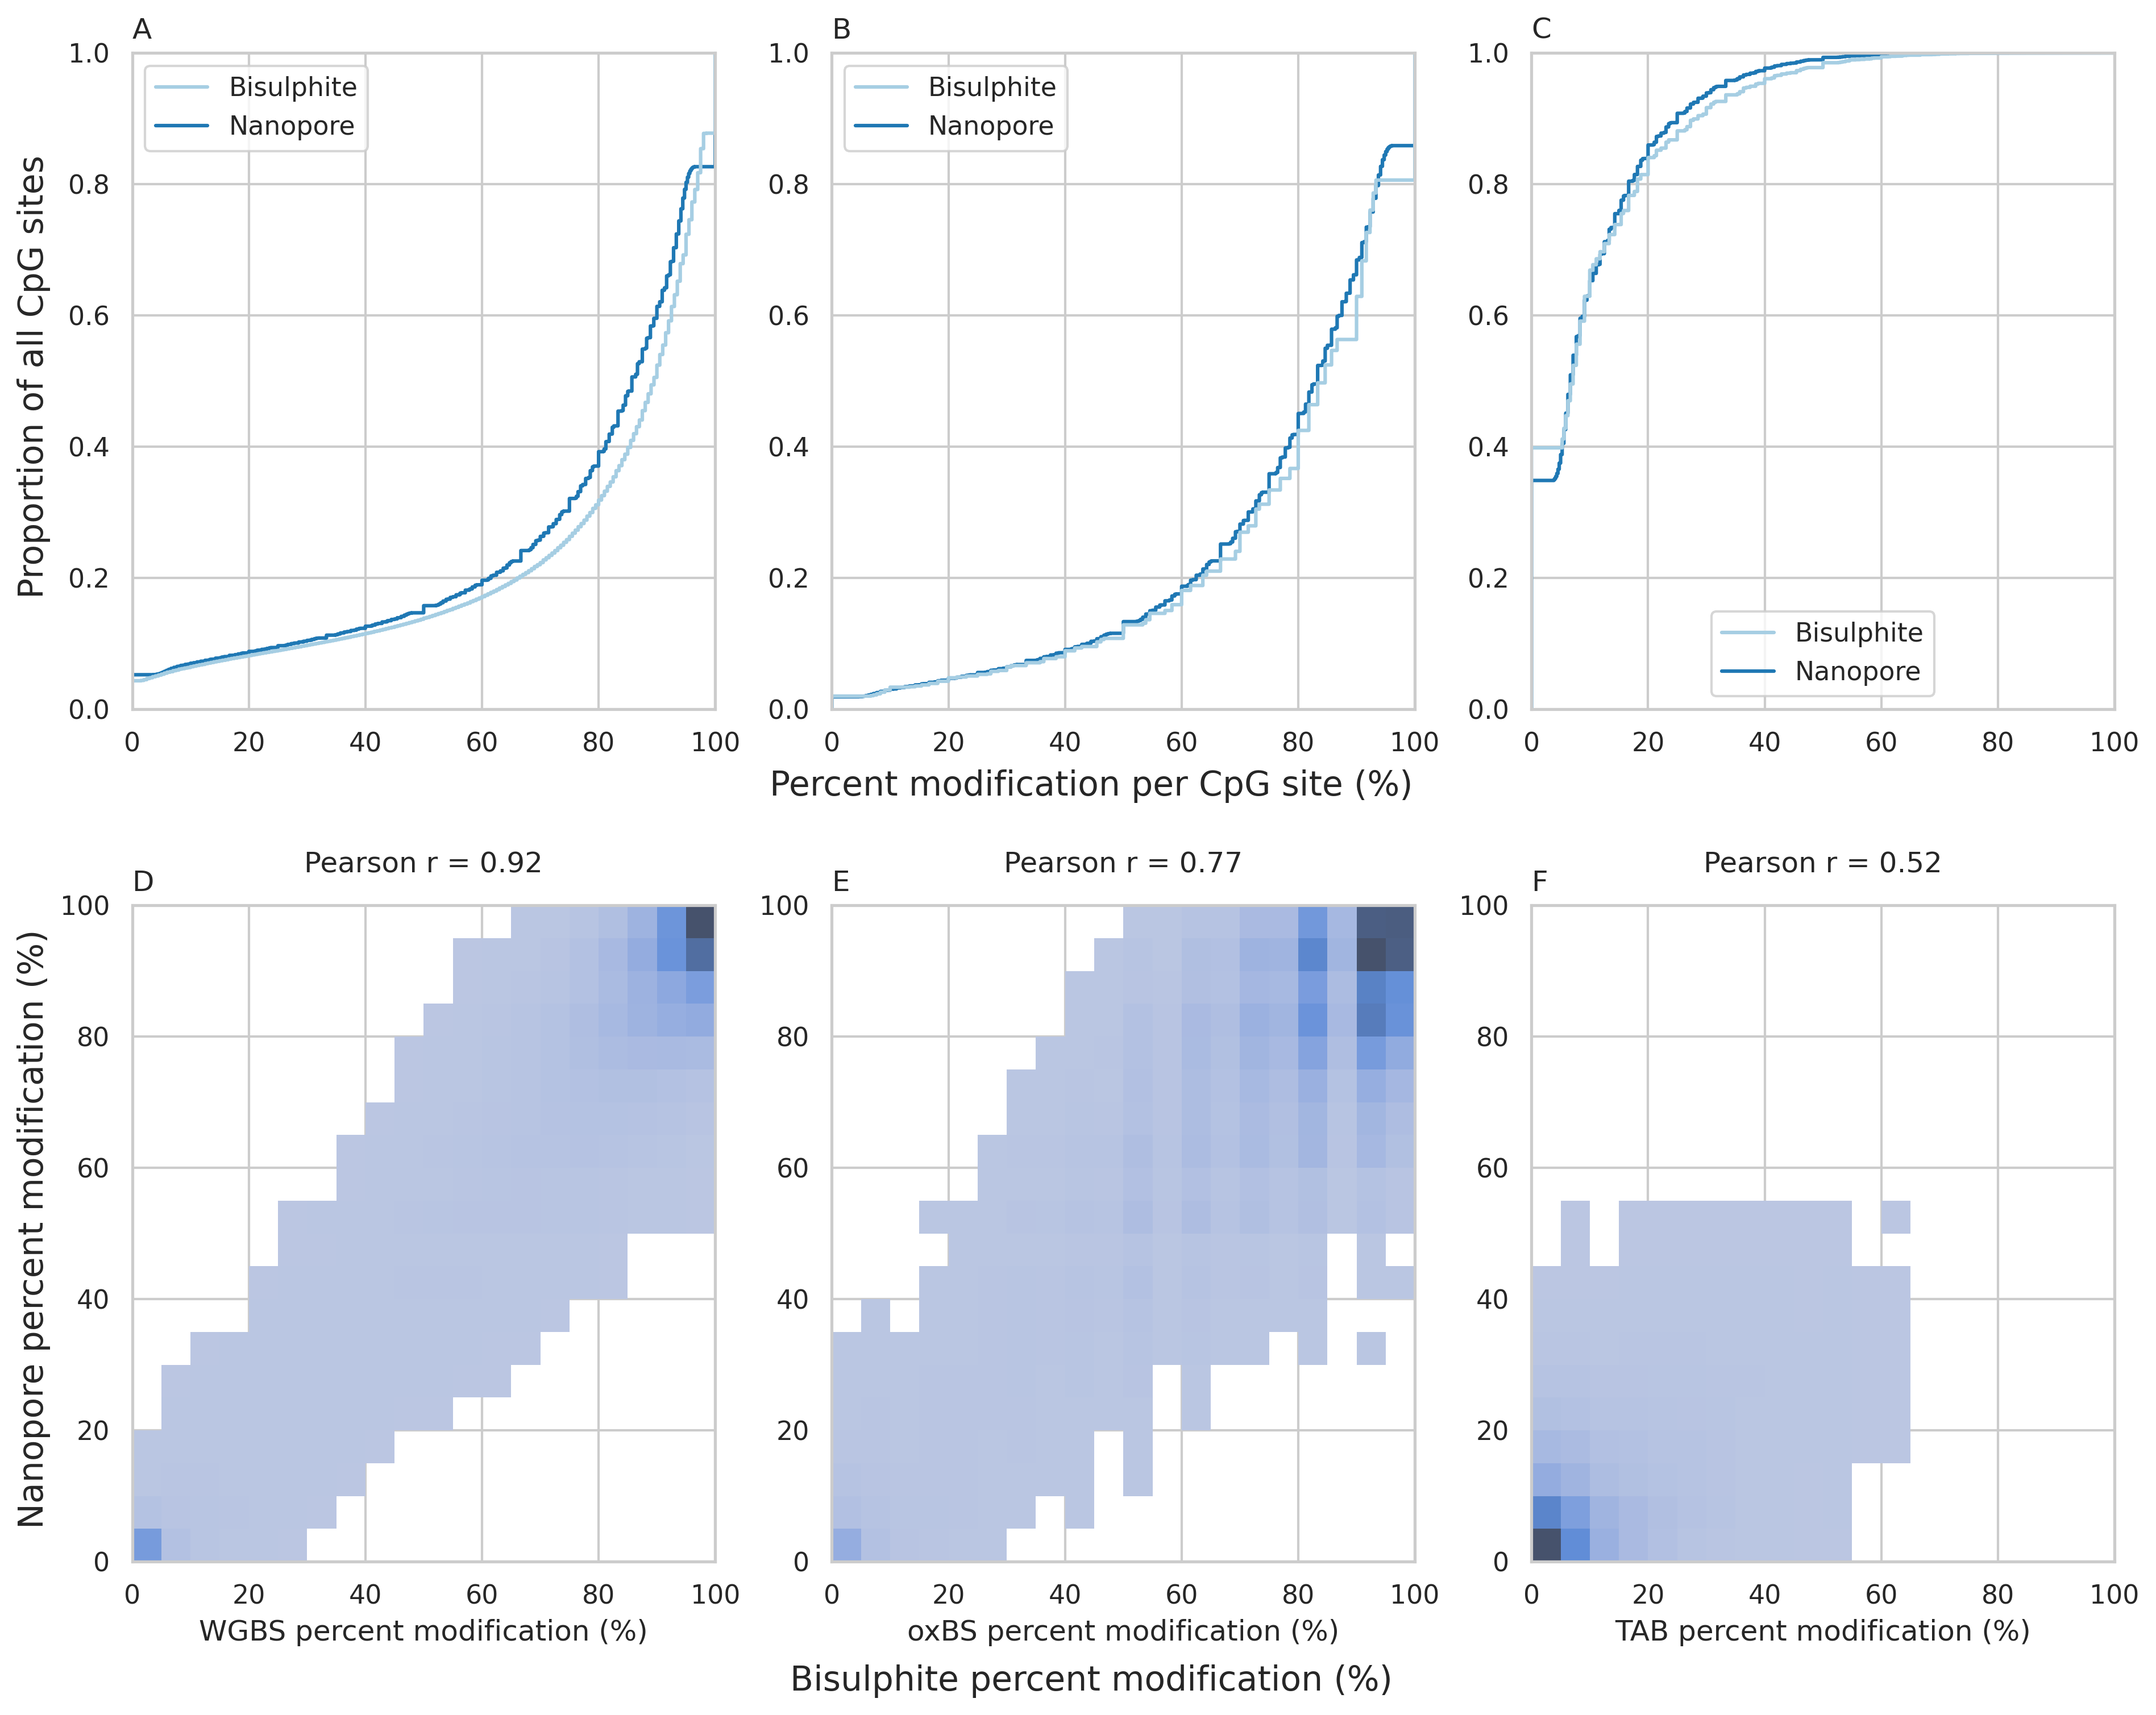

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")

fig1 = plt.figure(dpi=300, figsize=(15, 10)) 
gs1 = GridSpec(2, 1, fig1)

fig11 = fig1.add_subfigure(gs1[0, :])
gs11 = GridSpec(1, 3, fig11)
fig11.supxlabel("Percent modification per CpG site (%)", y=0)
fig11.supylabel("Proportion of all CpG sites", x=0.08)

ax1 = fig11.add_subplot(gs11[0, 0])
ax2 = fig11.add_subplot(gs11[0, 1])
ax3 = fig11.add_subplot(gs11[0, 2])

two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax1)
sns.move_legend(ax1, "upper left", title=None)
# ax1.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title("A", loc="left")
ax1.set_xlim([0, 100])

mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax2)
sns.move_legend(ax2, "upper left", title=None)
# ax2.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title("B", loc="left")
ax2.set_xlim([0, 100])

hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax3)
sns.move_legend(ax3, "lower center", title=None)
# ax3.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_xlim([0, 100])
ax3.set_title("C", loc="left")

fig12 = fig1.add_subfigure(gs1[1, :])
fig12.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig12.supylabel("Nanopore percent modification (%)", x=0.08)
gs12 = GridSpec(1, 3, fig12)

ax4 = fig12.add_subplot(gs12[0, 0])
ax5 = fig12.add_subplot(gs12[0, 1])
ax6 = fig12.add_subplot(gs12[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax4)
ax4.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax4.set_xlim((0, 100))
ax4.set_ylim((0, 100))
ax4.set_xlabel("WGBS percent modification (%)")
ax4.set_ylabel(None)
ax4.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax5)
ax5.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax5.set_xlim((0, 100))
ax5.set_ylim((0, 100))
ax5.set_xlabel("oxBS percent modification (%)")
ax5.set_ylabel(None)
ax5.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax6)
ax6.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax6.set_xlim((0, 100))
ax6.set_ylim((0, 100))
ax6.set_xlabel("TAB percent modification (%)")
ax6.set_ylabel(None)
ax6.set_title("F", loc="left")

fig1.show()

In [155]:
from sklearn import preprocessing
from sklearn import metrics
import numpy as np

def ROCmain(wide_df, ax, label):

    def ROCbinariser():
        binariser = preprocessing.Binarizer(threshold=50)
        wide_df["binarised"] = binariser.fit_transform(np.reshape(wide_df["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return wide_df

    def ROC():
        binarised_df = ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(ax, label):
        fpr, tpr = ROC()
        return ax.plot(fpr, tpr, "-", label=label)

    return plotROC(ax, label)

In [217]:
total_eg

,chromosome,chromStart,chromEnd,percentMeth_Bisulphite_5mC,percentMeth_Nanopore_5mC,percentMeth_Bisulphite_5hmC,percentMeth_Nanopore_5hmC,percentC_Nanopore,percentC_Bisulphite,predictions,truth
0,chr1,3050094,3050095,83.333333,95.00,0.000000,0.00,5.00,16.666667,5mC,C
1,chr1,3050095,3050096,71.428571,94.74,0.000000,0.00,5.26,28.571429,5mC,C
2,chr1,3050195,3050196,80.000000,76.00,0.000000,0.00,24.00,20.000000,5mC,C
3,chr1,3050223,3050224,76.923077,78.26,0.000000,0.00,21.74,23.076923,5mC,C
4,chr1,3050666,3050667,50.000000,88.00,0.000000,0.00,12.00,50.000000,5mC,C
...,...,...,...,...,...,...,...,...,...,...,...
125255,chr1,72610886,72610887,91.666667,100.00,11.111111,0.00,0.00,-2.777778,5mC,5mC
125256,chr1,72612125,72612126,81.818182,87.50,10.000000,0.00,12.50,8.181818,5mC,5mC
125257,chr1,72612339,72612340,63.636364,90.91,16.666667,8.33,0.76,19.696970,5mC,C
125258,chr1,72612390,72612391,100.000000,81.82,16.666667,18.18,0.00,-16.666667,5mC,5mC


In [214]:
mc_eg, hmc_eg = map(lambda df: df.drop(columns=["modification_type"]), [mc_df_wide, hmc_df_wide])
total_eg = pd.merge(mc_eg, hmc_eg, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])

total_eg["percentC_Nanopore"] = np.subtract(100, 
                                            np.add(total_eg["percentMeth_Nanopore_5mC"], total_eg["percentMeth_Nanopore_5hmC"])
                                            )
total_eg["percentC_Bisulphite"] = np.subtract(100, 
                                            np.add(total_eg["percentMeth_Bisulphite_5mC"], total_eg["percentMeth_Bisulphite_5hmC"])
                                            )

In [233]:
total_eg[["percentC_Nanopore", "percentMeth_Nanopore_5mC", "percentMeth_Nanopore_5hmC"]]

,percentC_Nanopore,percentMeth_Nanopore_5mC,percentMeth_Nanopore_5hmC
0,5.00,95.00,0.00
1,5.26,94.74,0.00
2,24.00,76.00,0.00
3,21.74,78.26,0.00
4,12.00,88.00,0.00
...,...,...,...
125255,0.00,100.00,0.00
125256,12.50,87.50,0.00
125257,0.76,90.91,8.33
125258,0.00,81.82,18.18


In [232]:
total_eg["predictions"] = np.select(
    [total_eg["percentC_Nanopore"] > total_eg["percentMeth_Nanopore_5mC"], total_eg["percentC_Nanopore"] > total_eg["percentMeth_Nanopore_5hmC"],
     total_eg["percentMeth_Nanopore_5mC"] > total_eg["percentMeth_Nanopore_5hmC"], total_eg["percentMeth_Nanopore_5mC"] > total_eg["percentC_Nanopore"],
     total_eg["percentMeth_Nanopore_5hmC"] > total_eg["percentMeth_Nanopore_5mC"], total_eg["percentMeth_Nanopore_5hmC"] > total_eg["percentC_Nanopore"]
     ],
    ["C", "C", "5mC", "5mC", "5hmC", "5hmC"])

total_eg["truth"] = np.select(
    [total_eg["percentC_Bisulphite"] > total_eg["percentMeth_Bisulphite_5mC"], total_eg["percentC_Bisulphite"] > total_eg["percentMeth_Bisulphite_5hmC"],
     total_eg["percentMeth_Bisulphite_5mC"] > total_eg["percentMeth_Bisulphite_5hmC"], total_eg["percentMeth_Bisulphite_5mC"] > total_eg["percentC_Bisulphite"],
     total_eg["percentMeth_Bisulphite_5hmC"] > total_eg["percentMeth_Bisulphite_5mC"], total_eg["percentMeth_Bisulphite_5hmC"] > total_eg["percentC_Bisulphite"]],
    [ "C", "C", "5mC", "5mC", "5hmC", "5hmC"])

In [229]:
total_eg.loc[total_eg["predictions"] == "C"]

,chromosome,chromStart,chromEnd,percentMeth_Bisulphite_5mC,percentMeth_Nanopore_5mC,percentMeth_Bisulphite_5hmC,percentMeth_Nanopore_5hmC,percentC_Nanopore,percentC_Bisulphite,predictions,truth
0,chr1,3050094,3050095,83.333333,95.00,0.000000,0.0,5.00,16.666667,C,C
1,chr1,3050095,3050096,71.428571,94.74,0.000000,0.0,5.26,28.571429,C,C
2,chr1,3050195,3050196,80.000000,76.00,0.000000,0.0,24.00,20.000000,C,C
3,chr1,3050223,3050224,76.923077,78.26,0.000000,0.0,21.74,23.076923,C,C
4,chr1,3050666,3050667,50.000000,88.00,0.000000,0.0,12.00,50.000000,C,C
...,...,...,...,...,...,...,...,...,...,...,...
125248,chr1,72601019,72601020,100.000000,93.33,7.142857,0.0,6.67,-7.142857,C,5mC
125250,chr1,72602282,72602283,75.000000,90.91,11.764706,0.0,9.09,13.235294,C,C
125252,chr1,72609488,72609489,70.000000,83.33,0.000000,0.0,16.67,30.000000,C,C
125253,chr1,72609733,72609734,85.714286,81.25,0.000000,0.0,18.75,14.285714,C,C


In [219]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(total_eg["truth"], total_eg["predictions"], normalize="true")

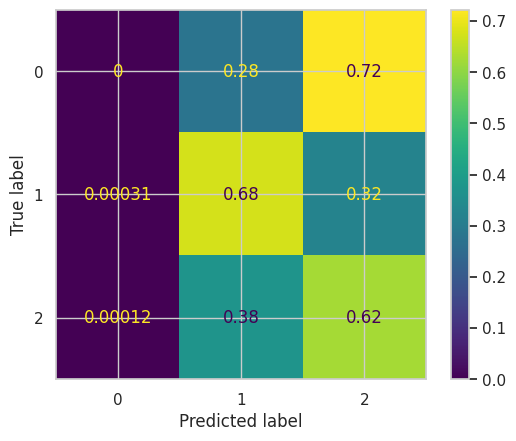

In [220]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(matrix).plot()

In [210]:
total_eg.loc[total_eg["predictions"] == "5hmC"]

,chromosome,chromStart,chromEnd,readCount_Bisulphite_5mC,percentMeth_Bisulphite_5mC,readCount_Nanopore_5mC,percentMeth_Nanopore_5mC,binarised_5mC,readCount_Bisulphite_5hmC,percentMeth_Bisulphite_5hmC,readCount_Nanopore_5hmC,percentMeth_Nanopore_5hmC,binarised_5hmC,percentC_Nanopore,percentC_Bisulphite,predictions,truth
117,chr1,3150170,3150171,11,90.909091,11,20.00,1.0,19,0.000000,11,54.55,0.0,25.45,9.090909,5hmC,C
282,chr1,3274170,3274171,15,33.333333,13,15.38,0.0,11,18.181818,13,23.08,0.0,61.54,48.484848,5hmC,C
420,chr1,3363084,3363085,12,16.666667,12,0.00,0.0,10,10.000000,12,25.00,0.0,75.00,73.333333,5hmC,C
508,chr1,3447829,3447830,11,36.363636,23,23.81,0.0,14,21.428571,23,30.43,0.0,45.76,42.207792,5hmC,C
512,chr1,3449353,3449354,12,25.000000,19,13.33,0.0,16,25.000000,19,31.58,0.0,55.09,50.000000,5hmC,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125020,chr1,72462008,72462009,13,38.461538,18,16.67,0.0,14,21.428571,18,38.89,0.0,44.44,40.109890,5hmC,C
125051,chr1,72473883,72473884,11,100.000000,11,25.00,1.0,17,17.647059,11,36.36,0.0,38.64,-17.647059,5hmC,5mC
125061,chr1,72477756,72477757,15,73.333333,19,12.50,1.0,18,22.222222,19,47.37,0.0,40.13,4.444444,5hmC,5mC
125108,chr1,72504516,72504517,10,30.000000,16,21.43,0.0,10,10.000000,16,31.25,0.0,47.32,60.000000,5hmC,C


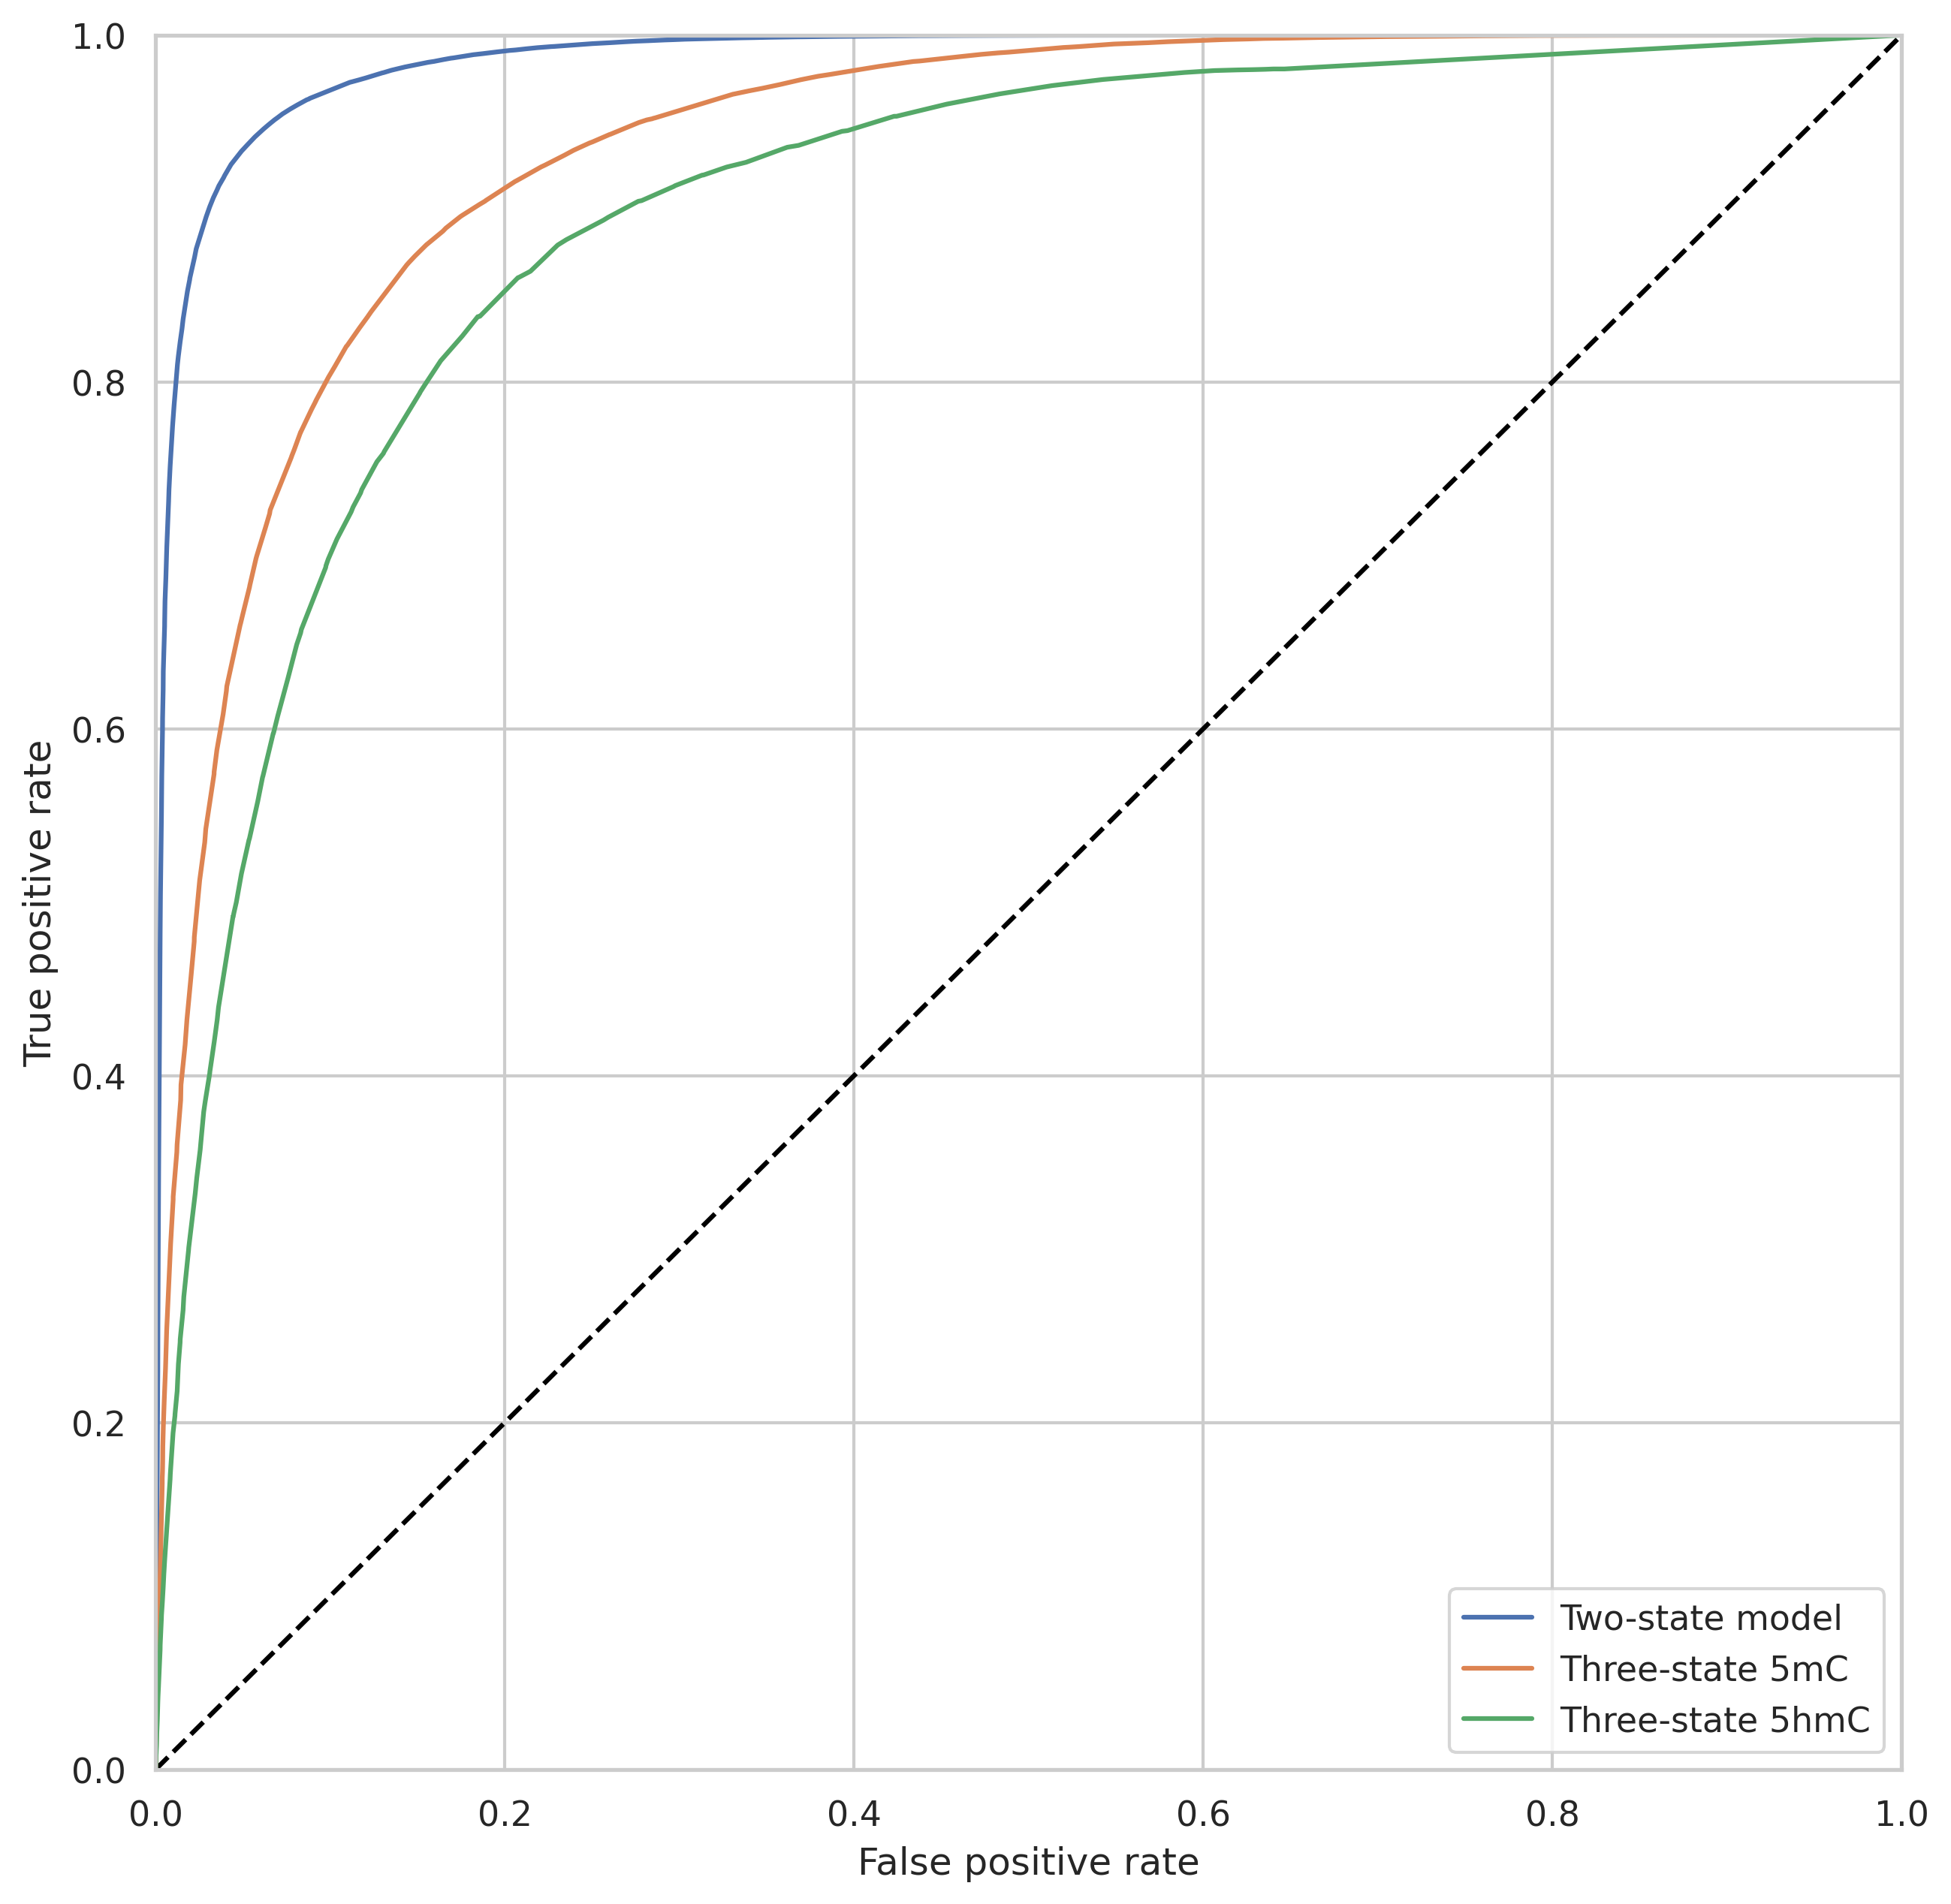

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")

fig2 = plt.figure(dpi=300, figsize=(10, 10)) 
gs2 = GridSpec(1, 1, fig2)

ax1 = fig2.add_subplot(gs2[0, 0])
ax1.plot(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01), "black", linestyle="--")
ROCmain(two_mod_wide, ax1, "Two-state model")
ROCmain(mc_df_wide, ax1, "Three-state 5mC")
ROCmain(hmc_df_wide, ax1, "Three-state 5hmC")
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.legend()

